In [1]:
import pandas as pd
import numpy as np
import xarray as xr

import hurdat as h
import tc_functions as fun
import plotting_functions as tcplt

import os

/Users/galen/anaconda3/envs/ada/lib/python3.7/site-packages/xarray/backends/cfgrib_.py:28: UserWarning: Failed to load cfgrib - most likely there is a problem accessing the ecCodes library. Try `import cfgrib` to get the full error message
  "Failed to load cfgrib - most likely there is a problem accessing the ecCodes library. "


In [34]:
# Get Kim's raw data and import while applying different RI cutoffs
nal_15 = pd.read_table("data/DTL_NAL_2015.txt", delimiter = ' ')
nal_16 = pd.read_table("data/DTL_NAL_2016.txt", delimiter = ' ')
nal_17 = pd.read_table("data/DTL_NAL_2017.txt", delimiter = ' ')
nal_18 = pd.read_table("data/DTL_NAL_2018.txt", delimiter = ' ')
nal_19 = pd.read_table("data/DTL_NAL_2019.txt", delimiter = ' ')
enp_15 = pd.read_table("data/DTL_ENP_2015.txt", delimiter = ' ')
enp_16 = pd.read_table("data/DTL_ENP_2016.txt", delimiter = ' ')
enp_17 = pd.read_table("data/DTL_ENP_2017.txt", delimiter = ' ')
enp_18 = pd.read_table("data/DTL_ENP_2018.txt", delimiter = ' ')
enp_19 = pd.read_table("data/DTL_ENP_2019.txt", delimiter = ' ')
total = pd.concat([nal_15, nal_16, nal_17, nal_18, nal_19, enp_15, enp_16, enp_17, enp_18, enp_19], ignore_index = True)

total.columns = ['YEAR', "PART_ID", "NAME", "DATETIME", "LAT", "LON", "WIND", "PRESSURE", "CATEGORY", "DISTANCE"]

total['DATETIME'] = pd.to_datetime(total['DATETIME'], format = "%Y%m%d%H")
total['NAME'] = total['NAME'].str.upper()
name_convert = {'UNNAMED04': 'FOUR', 
                'UNNAMED11': 'ELEVEN',
                'UNNAMED08': 'EIGHT'}
total['NAME'].loc[total['NAME'].str.contains('UNNAMED')] = [name_convert[x] for x in total['NAME'].loc[total['NAME'].str.contains('UNNAMED')]]
total['ID'] = total['PART_ID'] + total['YEAR'].astype(str)
hurdat_all = h.Hurdat(data = total)
# Filter storms by minimum intensity of 50
hurdat = hurdat_all.genesis_to_lysis_filter(minimum_wind = 50, keep_leading_n = 5) # 9/9/21 - Change to keep leading 5
# Add RI / RW labels to all storm observations
hurdat.identify_events(threshold = 25, col_names = ['25+', '25-'], drop_overlap=True)
hurdat.identify_events(threshold = 20, col_names = ['20+', '20-'], drop_overlap=True)
hurdat.identify_events(threshold = 15, col_names = ['15+', '15-'], drop_overlap=True)
# Add 250 km from land restriction as a column
hurdat.distance_to_land_label(min_distance = 250)

/Users/galen/anaconda3/envs/ada/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [2]:
#
storm_data = pd.read_csv('data/filtered_storm_list.csv')

In [9]:
#
storm_data = storm_data[storm_data['LEADING'] == False]
storm_data.reset_index(drop = True, inplace = True)

In [23]:
hurdat.storms['15-25'] = (hurdat.storms['15+'] & (~hurdat.storms['25+']))
hurdat.storms['m15-15'] = ~(hurdat.storms['25-'] | hurdat.storms['15-'] | hurdat.storms['15+'] | hurdat.storms['25+'])
hurdat.storms['m25-m15'] = (hurdat.storms['15-'] & (~hurdat.storms['25-']))

In [10]:
def get_storm_index(storm_df):
    jj = 0
    storm_id = ''
    storm_index = []
    for ii in range(len(storm_df)):
        curr_id = storm_df['ID'][ii]
        if curr_id != storm_id:
            storm_id = curr_id
            jj = 0
            storm_index.append(jj)
        else:
            jj = jj + 1
            storm_index.append(jj)
    
    return storm_index

In [ ]:
storm_data = hurdat.storms

In [11]:
storm_data['storm_index'] = get_storm_index(storm_data)

## Get some summary statistics

In [12]:
def get_ic_mean(x):
    id = str(x['ID'])
    strm_id = str(x['storm_index'])
    root = 'data/int_circ_keep-leading-5/' # CHANGE IF YOU WANT VORTEX REMOVED 6/21
    ic = np.load(root + id + '_' + strm_id + '.npy')
    return np.nanmean(ic)

def get_ic_min(x):
    id = str(x['ID'])
    strm_id = str(x['storm_index'])
    root = 'data/int_circ_keep-leading-5/' # CHANGE IF YOU WANT VORTEX REMOVED 6/21
    ic = np.load(root + id + '_' + strm_id + '.npy')
    return np.nanmin(ic)

In [13]:
storm_data['ic_mean'] = storm_data.apply(get_ic_mean, axis = 1)
storm_data['ic_min'] = storm_data.apply(get_ic_min, axis = 1)

In [14]:
ids = pd.unique(storm_data['ID'])
data = pd.DataFrame(columns=['storm', 'RI', 'shear_mag', 'shear_u', 'shear_v', 'velocity_u', 'velocity_v', 'center_lat', 'center_lon'])
ii = 1
for id in ids:
    f = xr.open_dataset('data/profiles_keep-leading-5/prof_' + id + '.nc') # CHANGE IF YOU WANT VORTEX REMOVED 6/21
    data = data.append( pd.DataFrame( np.column_stack( ( ii*np.ones(f.wind.values.size), f.ri.values, f.shear_mag.values, f.shear_u.values, f.shear_v.values, f.velocity_u.values, f.velocity_v.values, f.center_lat.values, f.center_lon.values ) ), columns=['storm', 'RI', 'shear_mag', 'shear_u', 'shear_v', 'velocity_u', 'velocity_v', 'center_lat', 'center_lon'] ), ignore_index = True )
    ii += 1

/Users/galen/anaconda3/envs/ada/lib/python3.7/site-packages/xarray/backends/plugins.py:61: RuntimeWarning: Engine 'cfgrib' loading failed:
dlopen(/Users/galen/anaconda3/envs/ada/lib/python3.7/site-packages/gribapi/_bindings.cpython-37m-darwin.so, 2): Symbol not found: _codes_bufr_key_is_header
  Referenced from: /Users/galen/anaconda3/envs/ada/lib/python3.7/site-packages/gribapi/_bindings.cpython-37m-darwin.so
  Expected in: /Users/galen/anaconda3/envs/ada/lib/libeccodes.dylib
 in /Users/galen/anaconda3/envs/ada/lib/python3.7/site-packages/gribapi/_bindings.cpython-37m-darwin.so
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


In [15]:
storm_data['shear_mag'] = data['shear_mag']
storm_data['shear_u'] = data['shear_u']
storm_data['shear_v'] = data['shear_v']
storm_data['velocity_u'] = data['velocity_u']
storm_data['velocity_v'] = data['velocity_v']
storm_data['center_lat'] = data['center_lat']
storm_data['center_lon'] = data['center_lon']

## IC Level Sets

In [20]:
def latlon_grid(center_lat, center_lon, radius = 800):
    data_lat = np.arange(-90, 90, 0.25)
    data_lon = np.arange(0, 360, 0.25)

    if center_lon > 180:
        center_lon = center_lon - 360

    min_lat, max_lat, min_lon, max_lon = fun.bounding_box(center_lat, center_lon, radius)

    lat_rows = np.where((data_lat >= min_lat) & (data_lat <= max_lat))[0]
    min_lat_ind = min(lat_rows) if min(lat_rows) == 0 else min(lat_rows) - 1
    max_lat_ind = max(lat_rows) if max(lat_rows) > (data_lat.size - 2) else max(lat_rows) + 2 
    lat_subset = data_lat[min_lat_ind:max_lat_ind]

    if min_lon < 90 and max_lon > 270:
        lon_rows_1 = np.where((data_lon >= max_lon))[0]
        lon_rows_2 = np.where((data_lon <= min_lon))[0]
        
        min_lon_ind_1 = min(lon_rows_1) - 1 
        max_lon_ind_1 = max(lon_rows_1)
        min_lon_ind_2 = min(lon_rows_2)
        max_lon_ind_2 = max(lon_rows_2) + 2

        lon_subset_1 = data_lon[min_lon_ind_1:max_lon_ind_1]
        lon_subset_2 = data_lon[min_lon_ind_2:max_lon_ind_2]
        lon_subset = np.concatenate((lon_subset_1, lon_subset_2), axis = 0)
    else:
        lon_rows = np.where((data_lon >= min_lon) & (data_lon <= max_lon))[0]

        min_lon_ind = min(lon_rows) if min(lon_rows) == 0 else min(lon_rows) - 1
        max_lon_ind = max(lon_rows) if max(lon_rows) > (data_lon.size - 2) else max(lon_rows) + 2

        lon_subset = data_lon[min_lon_ind:max_lon_ind]

    lat_grid, lon_grid = [x.T for x in np.meshgrid(lat_subset, lon_subset)]

    return [lat_grid, lon_grid]

# Program to count islands in boolean 2D matrix
class Graph:

    def __init__(self, row, col, g):
        self.ROW = row
        self.COL = col
        self.graph = g
        self.island_nums = np.zeros((row, col), dtype=int)
        self.counted = False

	# A function to check if a given cell
	# (row, col) can be included in DFS
    def isSafe(self, i, j, visited):
        # row number is in range, column number
        # is in range and value is 1
        # and not yet visited
        return (i >= 0 and i < self.ROW and
                j >= 0 and j < self.COL and
                not visited[i][j] and self.graph[i][j])
			

	# A utility function to do DFS for a 2D
	# boolean matrix. It only considers
	# the 8 neighbours as adjacent vertices
    def DFS(self, i, j, visited, island_num):

        # These arrays are used to get row and
        # column numbers of 8 neighbours
        # of a given cell
        rowNbr = [-1, -1, -1, 0, 0, 1, 1, 1]
        colNbr = [-1, 0, 1, -1, 1, -1, 0, 1]
        
        # Mark this cell as visited
        visited[i][j] = True
        self.island_nums[i,j] = island_num

        # Recur for all connected neighbours
        for k in range(8):
            if self.isSafe(i + rowNbr[k], j + colNbr[k], visited):
                self.DFS(i + rowNbr[k], j + colNbr[k], visited, island_num)


	# The main function that returns
	# count of islands in a given boolean
	# 2D matrix
    def countIslands(self):
        # Make a bool array to mark visited cells.
        # Initially all cells are unvisited
        visited = [[False for j in range(self.COL)]for i in range(self.ROW)]

        # Initialize count as 0 and traverse
        # through the all cells of
        # given matrix
        count = 0
        for i in range(self.ROW):
            for j in range(self.COL):
                # If a cell with value 1 is not visited yet,
                # then new island found
                if visited[i][j] == False and self.graph[i][j] == 1:
                    # Visit all cells in this island
                    # and increment island count
                    count += 1
                    self.DFS(i, j, visited, count)

        self.counted = True
        return count

    def islandTotals(self, pad_tot = 6):
        assert self.counted == True, "You must run countIslands() method before running islandTotals()."
        counts = np.bincount(self.island_nums.flatten())[1:]
        index_sorted = np.argsort(counts)[::-1]
        counts_sorted = counts[index_sorted]
        counts_padded = np.pad(counts_sorted, (0, pad_tot - len(counts_sorted)), 'constant')

        return counts_padded, index_sorted + 1, self.island_nums

def connected_components_analysis(x, cutoff = -0.5):
    id = str(x['ID'])
    strm_id = str(x['storm_index'])
    root = 'data/int_circ_keep-leading-5/' # CHANGE IF YOU WANT VORTEX REMOVED 6/21
    ic = np.load(root + id + '_' + strm_id + '.npy')
    center_lon = x['center_lon']
    center_lat = x['center_lat']

    if cutoff <= 0:
        ic_set = np.where(ic < cutoff, ic, np.nan)
        ic_bool = np.where(ic < cutoff, 1, 0)
    elif cutoff > 0:
        ic_set = np.where(ic > cutoff, ic, np.nan)
        ic_bool = np.where(ic > cutoff, 1, 0)

    # Connected components analysis
    ic_bool_row = ic_bool.shape[0]
    ic_bool_col = ic_bool.shape[1]
    ic_bool_list = ic_bool.tolist()
    g = Graph(ic_bool_row, ic_bool_col, ic_bool_list)
    connected_components = g.countIslands()
    conn_comp_sizes, label_order, labels = g.islandTotals(pad_tot = 6)

    return pd.Series(np.insert(conn_comp_sizes, 0, connected_components))


def get_ic_level_set(x, cutoff = -0.5, largest_island_only = True):
    id = str(x['ID'])
    strm_id = str(x['storm_index'])
    root = 'data/int_circ_keep-leading-5/' # CHANGE IF YOU WANT VORTEX REMOVED 6/21
    ic = np.load(root + id + '_' + strm_id + '.npy')
    center_lon = x['center_lon']
    center_lat = x['center_lat']

    if cutoff <= 0:
        ic_set = np.where(ic < cutoff, ic, np.nan)
        ic_bool = np.where(ic < cutoff, 1, 0)
    elif cutoff > 0:
        ic_set = np.where(ic > cutoff, ic, np.nan)
        ic_bool = np.where(ic > cutoff, 1, 0)

    if np.isnan(ic_set).all():
        return pd.Series({
            'ls_radius': np.nan, 
            'ls_velocity_angle': np.nan, 
            'ls_shear_angle': np.nan, 
            'ls_north_angle': np.nan,
            'ls_u': np.nan, 
            'ls_v': np.nan,
            'ls_size': 0,
            'ls_avg_ic': np.nan,
            'ls_num_components': 0
        })

    # Connected components analysis
    ic_bool_row = ic_bool.shape[0]
    ic_bool_col = ic_bool.shape[1]
    ic_bool_list = ic_bool.tolist()
    g = Graph(ic_bool_row, ic_bool_col, ic_bool_list)
    connected_components = g.countIslands()
    conn_comp_sizes, label_order, labels = g.islandTotals()
    if largest_island_only:
        ic_set = np.where(labels == label_order[0], ic_set, np.nan)

    lat_grid, lon_grid = latlon_grid(center_lat, center_lon)

    # Deal with case where lon grid passes the 360 - 0 barrier
    barrier = False
    if np.min(lon_grid) < 90 and np.max(lon_grid) > 270:
        barrier = True
        lon_grid = np.where(lon_grid < 90, lon_grid + 360, lon_grid)

    lat_grid_masked = np.ma.MaskedArray(lat_grid, mask = np.isnan(ic_set))
    lon_grid_masked = np.ma.MaskedArray(lon_grid, mask = np.isnan(ic_set))
    ic_set_masked = np.ma.MaskedArray(ic_set, mask = np.isnan(ic_set))

    set_size = np.count_nonzero(~np.isnan(ic_set))
    set_avg = np.nanmean(ic_set)

    avg_lat = np.ma.average(lat_grid_masked, weights = np.abs(ic_set_masked))
    avg_lon = np.ma.average(lon_grid_masked, weights = np.abs(ic_set_masked))

    if barrier and center_lon < 90:
        center_lon = center_lon + 360

    rad_to_level_set = fun.great_circ_dist(center_lat, center_lon, avg_lat, avg_lon)

    centered_avg_lat = avg_lat - center_lat
    centered_avg_lon = avg_lon - center_lon

    # Calculate angles on [0, 2pi] (moving counterclockwise) between the shear vector, the velocity vector, 
    # and north. Use technique from https://stackoverflow.com/questions/14066933/direct-way-of-computing-clockwise-angle-between-2-vectors/16544330#16544330
    dot = x['velocity_u'] * centered_avg_lon + x['velocity_v'] * centered_avg_lat
    det = x['velocity_u'] * centered_avg_lat - x['velocity_v'] * centered_avg_lon
    angle_velocity = np.arctan2(det, dot)
    if angle_velocity < 0:
        angle_velocity = angle_velocity + 2*np.pi

    dot = x['shear_u'] * centered_avg_lon + x['shear_v'] * centered_avg_lat
    det = x['shear_u'] * centered_avg_lat - x['shear_v'] * centered_avg_lon
    angle_shear = np.arctan2(det, dot)
    if angle_shear < 0:
        angle_shear = angle_shear + 2*np.pi

    dot = 0.0 * centered_avg_lon + 1.0 * centered_avg_lat
    det = 0.0 * centered_avg_lat - 1.0 * centered_avg_lon
    angle_north = np.arctan2(det, dot)
    if angle_north < 0:
        angle_north = angle_north + 2*np.pi
    
    return pd.Series({
        'ls_radius': rad_to_level_set, 
        'ls_velocity_angle': angle_velocity, 
        'ls_shear_angle': angle_shear, 
        'ls_north_angle': angle_north,
        'ls_u': centered_avg_lon, 
        'ls_v': centered_avg_lat,
        'ls_size': set_size,
        'ls_avg_ic': set_avg,
        'ls_num_components': connected_components
    })

In [22]:
complete_storm_data = storm_data.merge(storm_data.apply(get_ic_level_set, axis = 1, cutoff = -0.5), left_index = True, right_index = True)

In [42]:
# Add lagged columns for analysis in R
col_list = ['ls_radius', 'ls_velocity_angle', 'ls_shear_angle', 'ls_north_angle', 'ls_u', 'ls_v', 'ls_size', 'ls_avg_ic']
k = 4
for ii in range(k):
    new_col_list = [x + '-' + str(ii+1) for x in col_list]
    complete_storm_data[new_col_list] = complete_storm_data[col_list].shift(ii+1)
    complete_storm_data.loc[pd.isnull(complete_storm_data[new_col_list[6]]), new_col_list[6]] = 0

In [43]:
complete_storm_data = complete_storm_data[complete_storm_data['LEADING'] == False]
complete_storm_data.reset_index(inplace = True, drop = True)

In [44]:
complete_storm_data

,YEAR,PART_ID,NAME,DATETIME,LAT,LON,WIND,PRESSURE,CATEGORY,DISTANCE,...,ls_size-3,ls_avg_ic-3,ls_radius-4,ls_velocity_angle-4,ls_shear_angle-4,ls_north_angle-4,ls_u-4,ls_v-4,ls_size-4,ls_avg_ic-4
0,2015,AL01,ANA,2015-05-09 00:00:00,31.9,-77.3,50,998,SS,229,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN
1,2015,AL01,ANA,2015-05-09 06:00:00,32.2,-77.5,50,998,TS,194,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN
2,2015,AL01,ANA,2015-05-09 12:00:00,32.5,-77.8,50,1001,TS,152,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN
3,2015,AL02,BILL,2015-06-16 12:00:00,28.0,-96.0,50,997,TS,67,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN
4,2015,AL02,BILL,2015-06-16 18:00:00,28.2,-96.7,50,997,TS,8,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2552,2019,EP15,LORENA,2019-09-20 12:00:00,22.6,-108.8,65,989,HU,98,...,319.0,-0.818066,364.871892,0.808779,4.496862,1.483520,-3.487039,0.305113,276.0,-0.775207
2553,2019,EP15,LORENA,2019-09-20 18:00:00,23.0,-109.2,75,986,HU,38,...,388.0,-0.733184,294.712460,0.165342,3.651588,0.998323,-2.347959,1.513174,319.0,-0.818066
2554,2019,EP15,LORENA,2019-09-21 00:00:00,23.7,-109.5,70,987,HU,13,...,439.0,-0.721904,203.860104,5.914713,2.126699,0.558823,-0.993034,1.588066,388.0,-0.733184
2555,2019,EP15,LORENA,2019-09-21 06:00:00,24.2,-110.2,60,989,TS,0,...,476.0,-0.694721,124.924377,5.173438,1.312667,6.225089,0.065250,1.121862,439.0,-0.721904


## Export Data

In [12]:
storm_data.to_csv('data/int_circ_summary_detailed.csv', index = False)

In [45]:
complete_storm_data.to_csv('data/int_circ_level_set_summary_-0.5_lag-4.csv', index = False)

## Connected component analysis

In [41]:
cc = storm_data.apply(connected_components_analysis, axis = 1, cutoff = -0.5)
cc.columns = ['cc', 'comp1', 'comp2','comp3','comp4','comp5','comp6']

array([[<AxesSubplot:title={'center':'cc'}>]], dtype=object)

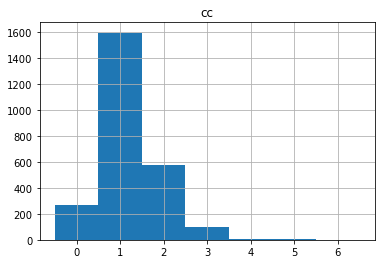

In [62]:
cc.hist('cc', bins = np.linspace(-0.5, 6.5, 8))

In [63]:
cc['ratio'] = cc['comp2']/cc['comp1']

array([[<AxesSubplot:title={'center':'ratio'}>]], dtype=object)

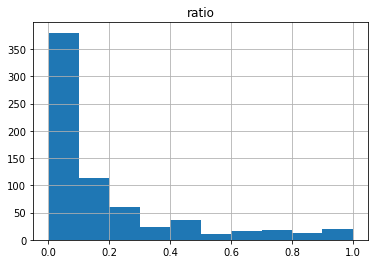

In [64]:
cc[cc['cc'] > 1].hist('ratio')